<h1 align="center">OpenMP part 2</h1> 

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [11]:
def solve_2d_nonlinearconv(u:'float[:,:]', un:'float[:,:]', v:'float[:,:]', vn:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', c:'int'):


    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #$ omp parallel
    #$ omp for collapse(3)
    
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        for i in range(1, row): 
            for j in range(1,col):
                u[i,j] = un[i,j] - un[i,j]  * dt / dx * (un[i,j] - un[i-1,j]) - vn[i,j]  * dt / dy * (un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - un[i,j]  * dt / dx * (vn[i,j] - vn[i-1,j]) - vn[i,j]  * dt / dy * (vn[i,j] - vn[i,j-1])
    
    #$ omp end parallel
    
    return 0



/tmp/ipykernel_6059/3555818656.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


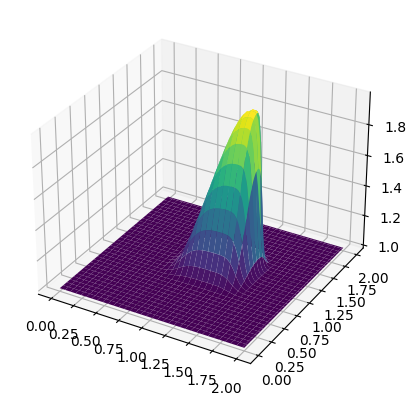

In [41]:
###variable declarations
nx = 101
ny = 101
nt = 80
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

solve_2d_nonlinearconv(u, un, v, vn, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


### Measure the code performance and plot the speedup curves obtained.

In [94]:
threads = 9
temps_execution = []
for i in range(1,threads):
    if __name__ == '__main__':
        from pyccel.epyccel import epyccel
        from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
        omp_set_num_threads(i)
        execute = epyccel(solve_2d_nonlinearconv, language="c", accelerators= ' openmp ')
        import timeit
        t1 = timeit.default_timer()

        execute(u, un, v, vn, nt, dt, dx, dy, c)
        temps_execution.append(timeit.default_timer() - t1)
print(temps_execution) 

[0.007921172998976544, 0.008371226998860948, 0.009627392999391304, 0.007749272999717505, 0.008014757000637474, 0.008334575999469962, 0.008307402000355069, 0.00846700700094516]


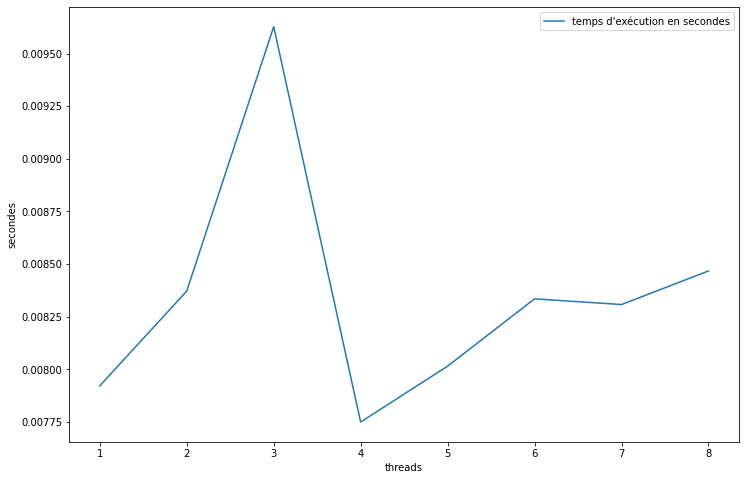

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [2]:
# write your code here
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time
import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy import init_printing
init_printing(use_latex=True)

In [3]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
un = np.zeros((ny, nx))
vn = np.zeros((ny, nx))
pn = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))


In [4]:
#$ omp sections 
#$ omp section

        #$ omp end section
        
        #$ omp section

        #$ omp end section
        
        #$ omp section

        #$ omp end section
        #$ omp end sections
        

    #$ omp end parallel

In [5]:
def navier_openmp(nit:'int',nt:'int', u:'float[:,:]',un:'float[:,:]',b:'float[:,:]',v:'float[:,:]', vn:'float[:,:]',dt:'float', nx:'int', ny:'int', dx:'float', dy:'float', p:'float[:,:]', pn:'float[:,:]',rho:'int', nu:'float'):
    #un = u
    #vn = v
    #b = u
    
    #$ omp parallel
    #$ omp for
    
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        

    #$ omp sections 
    #$ omp section
    
     # Calcul de p
        row, col = p.shape
        b[1:-1, 1:-1] = (rho * (1 / dt * 
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                         (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                              ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
        
    #$ omp end section
    
    #$ omp section
    
    # Calcul de p
        pn[:,:] = p[:,:]
    
        #$ omp for
        for q in range(nit):
            pn[:,:] = p[:,:]
            p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                                (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                                (2 * (dx**2 + dy**2)) -
                                dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                b[1:-1,1:-1])

            p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
            p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
            p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
            p[-1, :] = 0        # p = 0 at y = 2
    #$ omp end section
    
    #$ omp section
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
    #$ omp end section
    #$ omp end sections
    #$ omp end parallel
        
 #   return u, v, p

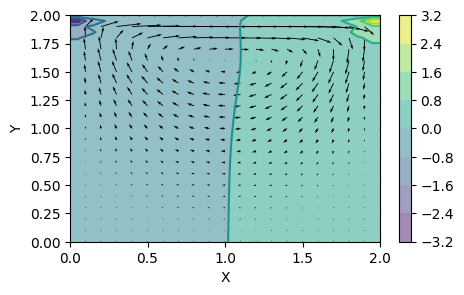

In [6]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
un = np.zeros((ny, nx))
vn = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
pn = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

navier_openmp(nit,nt,u, un, b ,v, vn, dt, nx, ny, dx, dy, p, pn, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

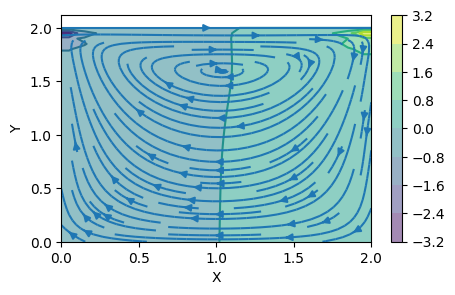

In [7]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

### Measure the code performance and plot the speedup curves obtained.

[0.07123574900015228, 0.06549455000003945, 0.06638806099999783, 0.06510849799997231, 0.06536202999996021, 0.06562894499984395, 0.06520770099996298, 0.06557975000032457]


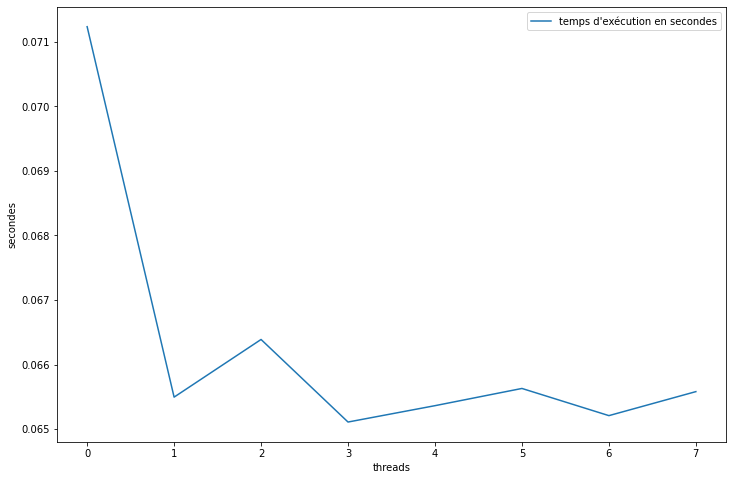

In [8]:
threads = 8
temps_execution = []
for i in range(0,threads):
    if __name__ == '__main__':
        from pyccel.epyccel import epyccel
        from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
        omp_set_num_threads(i)
        execute = epyccel(navier_openmp, language="c", accelerators= ' openmp ')
        import timeit
        t1 = timeit.default_timer()

        execute(nit,nt,u, un, b ,v, vn, dt, nx, ny, dx, dy, p, pn, rho, nu)
        temps_execution.append(timeit.default_timer() - t1)
print(temps_execution) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(0,8,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()